# Using Genex to identify marker genes

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')


In [2]:
#import os
#os.chdir("/content/drive/My Drive/BIOML/HIMANI")

In [1]:
import numpy as np
import pandas as pd
from scipy import stats

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression,RidgeClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import LinearSVC, SVC
from genex.filters.embedded import EmbeddedFilter
from genex.filters.mrmr import MRMRP
from genex.utils.help_functions import model_based_relevance, auc_relevance, load_DEGs
from sklearn.feature_selection import RFE,RFECV, SelectKBest, f_classif,SelectKBest, mutual_info_classif,chi2
from genex.eval.evaluate import do_train_test
from genex.eval.cross_validation import  do_cross_validation_with_feature_selection,do_cross_validation

%matplotlib inline
import matplotlib.pyplot as plt
#%matplotlib inline

#from matplotlib.pyplot import plt
import seaborn as sns
import warnings

# Comment these lines if you are not using Mac OS
import matplotlib as mpl
#mpl.use('MacOSX')
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# Set random seed
seed = 7
np.random.seed(seed)

## Inputs and parameters

In [3]:
# ========== INPUTS ==========

mydata = 'GSE136666_norm'


data_file = './data/'+ mydata +'.csv'

deg_lf_file = './data/'+ mydata +'_DEGS.csv'
degs_file = './data/'+ mydata +'_DEGS.txt'   # If None, all genes will be considered.
out_file = './results/'+ mydata +'/fs_scores.csv'

is_save_results = True

# data pre-processing
is_normalize_samples = False
is_normalize_columns = True
norm_filter = MinMaxScaler()

# experiment
num_folds = 5 #2
num_runs = 5  #2
label = 'disease'

# feature selection
# num_features = 10 #20
# fsm = MRMRP(relevance_func= auc_relevance, redundancy_func=stats.pearsonr, num_features=num_features)

models = {
    "LinearSVC": LinearSVC(),
    "RidgeClassifier" : RidgeClassifier(alpha=1.0, max_iter=1000, solver='auto', tol=1e-3),
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "SGDClassifier" : SGDClassifier(loss="log_loss", penalty="l2", random_state=seed,learning_rate='optimal')
}


top_markers_to_viz = 10    # set to zero to visualize all potential markers. was 10

In [4]:
if degs_file is not None and os.path.exists(degs_file):
    DEGs = load_DEGs(degs_file)
    # Keep only genes that exist in the dataframe columns
    DEGs = [gene for gene in DEGs if gene in df.columns]
    lenDEGs = len(DEGs)
    print(f"{lenDEGs} DEGs loaded and matched!")
else:
    lenDEGs = 0
    print("No DEGs provided or file not found. Pipeline will consider all genes.")

# def load_DEGs(path): if oen from simple text file. this will clean blanck space and blank lines
#     with open(path, 'r') as f:
#         return [line.strip() for line in f if line.strip()]


No DEGs provided or file not found. Pipeline will consider all genes.


In [5]:
df = pd.read_csv(data_file,low_memory=False)
df=df.set_index('GeneId')
df = df.transpose()

#df2 = pd.read_csv(deg_lf_file)


print('Shape of {0} is {1}'.format(data_file, df.shape))
theData = df
y = df[label]
df =df.drop([label],axis=1)
df.head()

Shape of ./data/GSE136666_norm.csv is (16, 21360)


GeneId,Gene_100287102,Gene_653635,Gene_102466751,Gene_100996442,Gene_729737,Gene_102725121,Gene_102723897,Gene_102465909,Gene_107985721,Gene_112268260,...,Gene_4538,Gene_4564,Gene_4575,Gene_4568,Gene_4540,Gene_4541,Gene_4556,Gene_4519,Gene_4576,Gene_4571
GSM4054763,0.680779,2.774167,1.316671,2.101168,2.419704,0.401048,2.779129,1.208967,0.849532,1.506750,...,5.482471,2.649103,2.799474,3.080346,5.191520,4.733479,3.738846,5.324706,2.849327,3.548086
GSM4054764,1.167584,2.882934,1.369827,1.951753,2.276893,1.129134,2.929272,1.346092,0.928276,1.746915,...,5.784443,2.978026,3.145917,3.340831,5.438464,5.022315,3.996462,5.513178,3.127750,3.815840
GSM4054765,1.285030,2.925723,1.535647,2.161555,2.261716,1.205510,2.974906,1.428171,1.028402,1.939556,...,5.626127,2.997555,3.075958,3.271978,5.367066,4.932047,3.882455,5.409575,2.969931,3.730584
GSM4054766,0.982851,2.874476,1.541439,2.166594,2.385287,1.064473,2.924496,1.497982,1.173566,1.737706,...,5.579404,2.671548,2.841360,3.098011,5.226773,4.774031,3.750852,5.367982,2.739500,3.472530
GSM4054767,0.905348,2.850889,1.541582,2.106363,2.278108,0.581686,2.924471,1.396928,1.252855,1.909959,...,5.663482,2.817755,2.988632,3.195870,5.351394,4.889068,3.903264,5.451644,2.920817,3.609562


In [6]:
# Load and process data
df = pd.read_csv(data_file, low_memory=False)
df = df.set_index('GeneId').transpose()
print(f"Shape of {data_file} is {df.shape}")

y = df[label]

if lenDEGs > 0:
    df = df[DEGs]
else:
    df = df.drop([label], axis=1)

print(f"Shape (Within DEGs) of {data_file} is {df.shape}")
names = df.columns
X = df.values


Shape of ./data/GSE136666_norm.csv is (16, 21360)
Shape (Within DEGs) of ./data/GSE136666_norm.csv is (16, 21359)


In [7]:
# Normalize per sample?
if is_normalize_samples:
    X = norm_filter.fit_transform(X.T, y).T
    print('Samples Normalized..')
# Normalize per sample
elif is_normalize_columns:
    X = norm_filter.fit_transform(X, y)
    print('Genes Normalized..')
else:
    print('No normalization used..')

Genes Normalized..


ACC	Sn	Sp	MCC	AUC
[0.7  0.66 0.72 0.38 0.69]
ACC	Sn	Sp	MCC	AUC
[0.76666667 0.68       0.88       0.56618802 0.78      ]
ACC	Sn	Sp	MCC	AUC
[0.75       0.7        0.84       0.54928203 0.91      ]
ACC	Sn	Sp	MCC	AUC
[0.79333333 0.8        0.8        0.61237604 0.93      ]


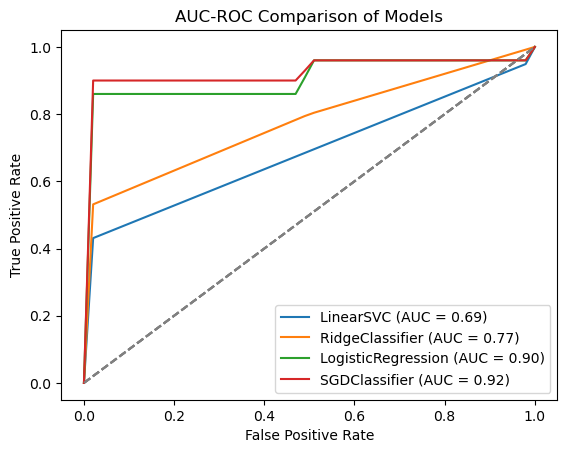

In [8]:
from sklearn.metrics import roc_curve, auc


with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for model_name, model in models.items():
        tprs, aucs, mean_fpr = [], [], np.linspace(0, 1)
        fsm=RFE(estimator=model,n_features_to_select=20,step=200)
        res2,scores = do_cross_validation_with_feature_selection(X, y,model=model, num_folds=num_folds,
                                                              fs_model=fsm, n_runs=num_runs)
        print('ACC\tSn\tSp\tMCC\tAUC')
        print(res2['metrics'])
        #print(res2)
        fpr = res2['fpr']
        tpr = res2['tpr']
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = np.mean(aucs)
        plt.plot(mean_fpr, mean_tpr, label=f'{model_name} (AUC = {mean_auc:.2f})')
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('AUC-ROC Comparison of Models')
    plt.legend()
    plt.show()


In [10]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    res2, scores = do_cross_validation_with_feature_selection(X, y,model=model, num_folds=num_folds,
                                                              fs_model=fsm, n_runs=num_runs)
    print('ACC\tSn\tSp\tMCC\tAUC')
    print(res2['metrics'])
    #print(scores)

    dict = {'feature': names, 'score': scores}
    df_score = pd.DataFrame(dict, columns=['feature', 'score'],index=None)
    df_score[df_score['score']>0].sort_values(by='score',ascending=False)


ACC	Sn	Sp	MCC	AUC
[0.79333333 0.8        0.8        0.61237604 0.93      ]


In [9]:
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Assume you already have these from before
# df = your dataframe with gene expression (samples x genes)
# y = label vector (same length as number of samples)
# names = list of gene names (column names of df)
# X = df.values (gene expression matrix)

# === 1. Train both models ===
sgd = SGDClassifier(random_state=42, max_iter=1000, tol=1e-3)
log = LogisticRegression(random_state=42, max_iter=1000)

sgd.fit(X, y)
log.fit(X, y)

# === 2. Get absolute coefficient scores for genes ===
sgd_scores = np.abs(sgd.coef_).flatten()
log_scores = np.abs(log.coef_).flatten()

# === 3. Normalize both scores between 0 and 1 ===
scaler = MinMaxScaler()
sgd_norm = scaler.fit_transform(sgd_scores.reshape(-1, 1)).flatten()
log_norm = scaler.fit_transform(log_scores.reshape(-1, 1)).flatten()

# === 4. Combine scores ===
combined_score = sgd_norm + log_norm

# === 5. Rank genes ===
top_indices = np.argsort(combined_score)[::-1]  # descending order
top_genes = [names[i] for i in top_indices]
top_scores = [combined_score[i] for i in top_indices]

# === 6. Display top N genes ===
N = 20
print(f"\nTop {N} Genes based on combined score:\n")
for i in range(N):
    print(f"{i+1:2d}. {top_genes[i]} — Score: {top_scores[i]:.4f}")



Top 20 Genes based on combined score:

 1. Gene_101927834 — Score: 1.8865
 2. Gene_399975 — Score: 1.8812
 3. Gene_83734 — Score: 1.8424
 4. Gene_26167 — Score: 1.7662
 5. Gene_102724064 — Score: 1.6559
 6. Gene_102723508 — Score: 1.6503
 7. Gene_54209 — Score: 1.6482
 8. Gene_102467073 — Score: 1.6373
 9. Gene_112770 — Score: 1.6134
10. Gene_9455 — Score: 1.6076
11. Gene_50485 — Score: 1.6058
12. Gene_100873165 — Score: 1.6058
13. Gene_57488 — Score: 1.6054
14. Gene_9298 — Score: 1.5987
15. Gene_11264 — Score: 1.5982
16. Gene_100526832 — Score: 1.5968
17. Gene_107985219 — Score: 1.5855
18. Gene_340205 — Score: 1.5723
19. Gene_375248 — Score: 1.5719
20. Gene_441884 — Score: 1.5647
